### Notebook for gLV Fitting (Stein et al. 2013)

In [31]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
import networkx as nx

In [32]:
ds_1 = pd.read_excel('../dataset/dataset_1.xlsx', sheet_name='Y') # read the estimated absolute abundance dataset
ds_1.head(18)

,Population,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,...,3.22,3.23,3.24,3.25,3.26,3.27,3.28,3.29,3.30,3.31
0,Replicate,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
1,ID,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
2,time (in d),0.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,9.000000,12.000000,...,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,9.000000,12.000000,16.000000,23.000000
3,Data matrix Y with processed and estimated den...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,undefined_genus_of_Enterobacteriaceae,0.000024,0.869140,0.415010,5.099800,0.429160,0.240180,0.142250,0.469020,0.581790,...,0.745030,2.958400,0.038304,0.022066,2.051100,2.029700,2.738900,6.181000,2.059900,2.131800
5,Blautia,0.000867,0.000040,0.007240,0.004735,2.394700,2.600600,0.118870,0.109960,0.164500,...,0.000038,0.000117,0.000331,0.000818,0.065322,0.042801,0.045325,1.285600,0.654260,1.664900
6,Barnesiella,0.092745,0.000168,0.000129,0.002360,0.000855,0.000688,0.000107,0.000120,0.000188,...,0.000138,0.000425,0.000014,0.000019,0.000715,0.000991,0.000433,0.001548,0.000975,0.001939
7,undefined_genus_of_unclassified_Mollicutes,0.001445,0.000337,0.000517,0.004545,0.001648,0.001325,0.022957,0.116230,0.224870,...,0.000060,0.000186,0.000095,0.000094,0.001188,0.000433,0.000189,0.082272,0.000426,4.653300
8,undefined_genus_of_Lachnospiraceae,0.219580,0.000115,0.000088,0.001612,0.000584,0.000470,0.000073,0.000082,0.000128,...,0.000150,0.000461,0.000024,0.000094,0.000777,0.001077,0.000471,0.001682,0.001059,0.002106
9,Akkermansia,0.033082,0.000197,0.051716,0.009470,0.506420,0.311960,0.284510,0.000141,0.000221,...,0.000158,0.000486,0.000851,0.000535,0.001188,0.001135,0.000496,0.001772,0.001116,0.003220


Define the function for forward difference quotient algorithm.

In [33]:
def forward_diff_quotient(abundance, time):
    
    diff_quotient = np.empty((11,0)) # Initialize an empty array to store the difference quotients

    for i in range(abundance.shape[1] - 1):
        diff_quotient_i = (np.log(abundance[:, i + 1]) - np.log(abundance[:, i])) / (time[i + 1] - time[i])
        diff_quotient_i = diff_quotient_i.reshape(11, 1)  # Reshape to ensure it is a column vector

        for j in range(11):
            if np.isnan(diff_quotient_i[j, 0]):
                diff_quotient_i[j, 0] = 0
                
            if np.isinf(diff_quotient_i[j, 0]):
                diff_quotient_i[j, 0] = 0
                
        diff_quotient = np.hstack((diff_quotient, diff_quotient_i))
        
    return diff_quotient

Compute the forward difference quotient for each ID group. Access adundance, perturbation and time data for each ID group.

In [34]:
start_index = 1
id_max = 9
all_abundance = np.empty((11, 0))  # Empty array to store all abundance data
all_abundance_with_end = np.empty((11, 0))  # Empty array to store all abundance data (with end)
all_diff_quotient = np.empty((11, 0))  # Empty array to store all difference quotients
all_time_data = []  # Initialize a list to store time data for each id
all_time = [] # Initialize a list to store time data for each id
all_perturb_data = np.empty((1, 0)) # Initialize a list to store perturbation data for each id
growth_vector = np.ones((1, ds_1.shape[1] - (id_max + 1))) # Initialize a growth vector with ones

for i in range(1, id_max + 1):
    for j in range(start_index, ds_1.shape[1]):
        id_value = ds_1.iloc[1, j] # get the id value from the second row

        if id_value != i or j == ds_1.shape[1] - 1:  # check if the id value does not match the current id or if it's the last column
            if j == ds_1.shape[1] - 1:  # if it's the last column, include it in the current id
                j += 1
           
            id_abundance = ds_1.iloc[4:15, start_index:j].to_numpy() # get the abundance data from rows 4 to 15 and columns from start_index to j
            id_perturb = ds_1.iloc[16, start_index:j - 1].to_numpy() # get the perturbation data from the fourth row and columns from start_index to j
            all_abundance = np.hstack((all_abundance, id_abundance[:, :-1])) # remove the last column data as there is no estimated derivative for the last column
            all_abundance_with_end = np.hstack((all_abundance_with_end, id_abundance))
            all_perturb_data = np.hstack((all_perturb_data, id_perturb.reshape(1, -1))).astype(float) # append the perturbation data to all_perturb_data
            all_time_data += [f'{i}_{ds_1.iloc[2, k]}' for k in range(start_index, j - 1)] # store the time data for the current id in all_time_data

            id_time = ds_1.iloc[2, start_index:j].to_numpy() # get the time data from the third row and columns from start_index to j
            all_time.append(id_time)
            id_qupotient = forward_diff_quotient(id_abundance, id_time) # calculate the difference quotient for the current id
            all_diff_quotient = np.hstack((all_diff_quotient, id_qupotient)) # append the difference quotient to the all_diff_quotient array

            start_index = j # update start_index to the next column

            break

C:\Users\LBY\AppData\Local\Temp\ipykernel_30004\792295042.py:6: RuntimeWarning: divide by zero encountered in log
  diff_quotient_i = (np.log(abundance[:, i + 1]) - np.log(abundance[:, i])) / (time[i + 1] - time[i])
C:\Users\LBY\AppData\Local\Temp\ipykernel_30004\792295042.py:6: RuntimeWarning: invalid value encountered in subtract
  diff_quotient_i = (np.log(abundance[:, i + 1]) - np.log(abundance[:, i])) / (time[i + 1] - time[i])


Here are the two matrixes obatined for paramterisation (F = (M Mu E) Y):

In [35]:
Y = pd.DataFrame(np.vstack((all_abundance, growth_vector, all_perturb_data)), columns=all_time_data, index=ds_1.iloc[4:17, 0].to_list()) # create a DataFrame with all abundance, growth vector, and perturbation data

# Y.to_csv('../dataset/Y.csv', index=True) # save the DataFrame to a CSV file
display(Y)
F = pd.DataFrame(all_diff_quotient, columns=all_time_data, index=ds_1.iloc[4:15, 0].to_list()) # create a DataFrame with all difference quotients
display(F)
# F.to_csv('../dataset/F.csv', index=True) # save the DataFrame to a CSV file

,1_0.0,1_2.0,1_3.0,1_4.0,1_5.0,1_6.0,1_7.0,1_9.0,1_12.0,1_16.0,...,9_0.0,9_2.0,9_3.0,9_4.0,9_5.0,9_6.0,9_7.0,9_9.0,9_12.0,9_16.0
undefined_genus_of_Enterobacteriaceae,0.000024,0.869140,0.415010,5.099800,0.429160,0.240180,0.142250,0.469020,0.581790,0.003252,...,0.000267,0.745030,2.958400,0.038304,0.022066,2.051100,2.029700,2.738900,6.181000,2.059900
Blautia,0.000867,0.000040,0.007240,0.004735,2.394700,2.600600,0.118870,0.109960,0.164500,0.004687,...,0.004546,0.000038,0.000117,0.000331,0.000818,0.065322,0.042801,0.045325,1.285600,0.654260
Barnesiella,0.092745,0.000168,0.000129,0.002360,0.000855,0.000688,0.000107,0.000120,0.000188,0.000007,...,1.397000,0.000138,0.000425,0.000014,0.000019,0.000715,0.000991,0.000433,0.001548,0.000975
undefined_genus_of_unclassified_Mollicutes,0.001445,0.000337,0.000517,0.004545,0.001648,0.001325,0.022957,0.116230,0.224870,0.019142,...,0.002020,0.000060,0.000186,0.000095,0.000094,0.001188,0.000433,0.000189,0.082272,0.000426
undefined_genus_of_Lachnospiraceae,0.219580,0.000115,0.000088,0.001612,0.000584,0.000470,0.000073,0.000082,0.000128,0.000005,...,1.067200,0.000150,0.000461,0.000024,0.000094,0.000777,0.001077,0.000471,0.001682,0.001059
Akkermansia,0.033082,0.000197,0.051716,0.009470,0.506420,0.311960,0.284510,0.000141,0.000221,0.000008,...,0.000348,0.000158,0.000486,0.000851,0.000535,0.001188,0.001135,0.000496,0.001772,0.001116
Clostridium_difficile,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000171,0.003528,0.000095,0.018446,0.198340,0.120170,0.012950,0.241680,3.208200
unclassified_Lachnospiraceae,0.032505,0.000075,0.000058,0.001060,0.000384,0.000309,0.000048,0.000054,0.000084,0.000003,...,0.200510,0.000103,0.000318,0.000011,0.000014,0.000535,0.000742,0.000324,0.001158,0.000730
Coprobacillus,0.000144,0.000253,0.001810,1.089100,0.001717,0.001037,0.000161,0.000181,0.000283,0.000011,...,0.003536,0.000019,0.040217,0.000002,0.002550,0.015440,1.242800,0.000060,0.000215,0.000136
Enterococcus,0.000037,0.002358,0.001034,0.151520,0.017166,0.001380,0.003862,0.000482,0.000096,0.000014,...,0.000116,0.000052,0.006350,0.022236,0.001700,0.023754,0.055970,0.000165,0.010285,0.011336


,1_0.0,1_2.0,1_3.0,1_4.0,1_5.0,1_6.0,1_7.0,1_9.0,1_12.0,1_16.0,...,9_0.0,9_2.0,9_3.0,9_4.0,9_5.0,9_6.0,9_7.0,9_9.0,9_12.0,9_16.0
undefined_genus_of_Enterobacteriaceae,5.259002,-0.739202,2.508654,-2.475127,-0.580441,-0.523803,0.596530,0.071821,-1.296748,0.219103,...,3.966778,1.378979,-4.346850,-0.551516,4.532094,-0.010488,0.149834,0.271308,-0.274706,0.004901
Blautia,-1.536512,5.195640,-0.424611,6.225989,0.082484,-3.085467,-0.038957,0.134265,-0.889529,0.179856,...,-2.392491,1.122824,1.041797,0.905813,4.379696,-0.422767,0.028649,1.115041,-0.168869,0.133431
Barnesiella,-3.157150,-0.264505,2.907570,-1.014700,-0.217973,-1.861527,0.058408,0.149204,-0.822159,0.120089,...,-4.611763,1.125142,-3.396453,0.286750,3.630489,0.326413,-0.413854,0.424548,-0.115561,0.098197
undefined_genus_of_unclassified_Mollicutes,-0.727930,0.428626,2.173343,-1.014681,-0.217997,2.852361,0.810974,0.219984,-0.615909,0.118930,...,-1.756781,1.125773,-0.674320,-0.000995,2.531926,-1.009290,-0.413655,2.024871,-1.315843,1.328382
undefined_genus_of_Lachnospiraceae,-3.778707,-0.264528,2.907577,-1.014675,-0.217997,-1.861523,0.058385,0.149208,-0.822137,0.120091,...,-4.435624,1.125138,-2.971922,1.385331,2.107373,0.326435,-0.413845,0.424531,-0.115549,0.098182
Akkermansia,-2.561365,5.569507,-1.697628,3.979227,-0.484491,-0.092107,-3.804421,0.149207,-0.822145,0.120093,...,-0.395408,1.125160,0.559231,-0.463564,0.797302,-0.045827,-0.413857,0.424562,-0.115559,0.151363
Clostridium_difficile,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.024780,-3.619587,5.273760,2.375135,-0.501075,-1.113906,0.975506,0.646463,-0.007393
unclassified_Lachnospiraceae,-3.033085,-0.264729,2.907585,-1.014698,-0.217602,-1.862043,0.058218,0.149328,-0.822111,0.120125,...,-3.785975,1.125037,-3.396521,0.286789,3.630499,0.326432,-0.413864,0.424540,-0.115496,0.098141
Coprobacillus,0.280351,1.967432,6.399725,-6.452761,-0.504014,-1.861503,0.058398,0.149207,-0.822151,0.120092,...,-2.607786,7.646979,-9.919403,7.161089,1.800986,4.388161,-4.967752,0.424778,-0.114634,0.097745
Enterococcus,2.079622,-0.824131,4.986993,-2.177787,-2.520557,1.028812,-1.040208,-0.537182,-0.480645,0.120088,...,-0.395052,4.796178,1.253258,-2.571202,2.637240,0.857065,-2.913919,1.377903,0.024324,-0.022844


In [36]:
Y_data = Y.to_numpy()  # Convert Y DataFrame to a NumPy array
F_data = F.to_numpy()  # Convert F DataFrame to a NumPy array

# Use the optimal regularisation factors from the paper
lmd = [2.25 for _ in range(11)] + [9, 0.25]
D_lmd = np.diag(lmd) # Create a diagonal matrix D with the regularisation factors

Solve the parameters analyticall via matrix operations:

In [37]:
# Define the parameter matrix as theta
theta = F_data @ Y_data.T @ np.linalg.inv(Y_data @ Y_data.T + D_lmd)  # Calculate theta using the formula

species = F.index.to_list()
parameter_matrix = pd.DataFrame(theta, index=F.index, columns=species + ['Growth', 'Susceptibility'])  # Create a DataFrame for the parameter matrix
display(parameter_matrix)  # Display the parameter matrix
# parameter_matrix.to_csv('../dataset/parameter_matrix.csv', index=True)  # Save the parameter matrix to a CSV file

,undefined_genus_of_Enterobacteriaceae,Blautia,Barnesiella,undefined_genus_of_unclassified_Mollicutes,undefined_genus_of_Lachnospiraceae,Akkermansia,Clostridium_difficile,unclassified_Lachnospiraceae,Coprobacillus,Enterococcus,Other,Growth,Susceptibility
undefined_genus_of_Enterobacteriaceae,-0.401416,0.064448,-0.395947,0.129798,0.258638,-0.248722,0.277620,0.221988,-0.409349,-0.040558,-0.119437,0.372998,3.659729
Blautia,0.082845,-0.729243,-0.189086,0.088353,-0.096796,-0.541217,0.137478,0.016777,0.531936,0.221563,-0.012077,0.787417,-1.419162
Barnesiella,-0.291869,-0.179284,-0.238253,0.273088,0.059044,-0.523514,0.297196,0.126275,-0.407331,0.007996,-0.085713,0.423602,-3.336973
undefined_genus_of_unclassified_Mollicutes,-0.294141,0.228020,-0.182539,-0.224853,-0.118034,-0.198952,0.061611,-0.080284,-0.464440,-0.067353,0.254499,0.531300,-1.154237
undefined_genus_of_Lachnospiraceae,-0.217574,-0.220323,0.042882,0.251521,-0.152808,-0.468404,0.259265,-0.038681,-0.427313,0.021724,-0.098702,0.364217,-3.080158
Akkermansia,-0.113216,0.402430,-0.170199,-0.270320,-0.251251,-1.242526,-0.425613,-0.124158,1.358575,0.183038,0.547015,0.274855,-0.968827
Clostridium_difficile,-0.015130,-0.110303,-0.008635,0.020970,-0.032579,-0.199669,-0.050175,-0.010178,-0.303308,0.015689,-0.166238,0.430753,-0.347657
unclassified_Lachnospiraceae,-0.228790,-0.199285,0.123080,0.255240,-0.242925,-0.514914,0.252295,-0.101658,-0.788143,-0.006511,-0.071611,0.413432,-2.140453
Coprobacillus,-0.232497,-0.522692,-0.074518,0.157941,-0.024075,-0.607089,0.429261,0.075126,-4.371048,-0.226587,-0.464684,0.925170,-0.872273
Enterococcus,0.016246,-0.341690,-0.018802,0.092951,-0.001947,0.041230,0.128399,0.044957,-2.095000,-0.189268,-0.197988,0.328035,1.035573


Visualise the computed model parameters including self-growth rates, microbial interaction factors and susceptibility to perturbation

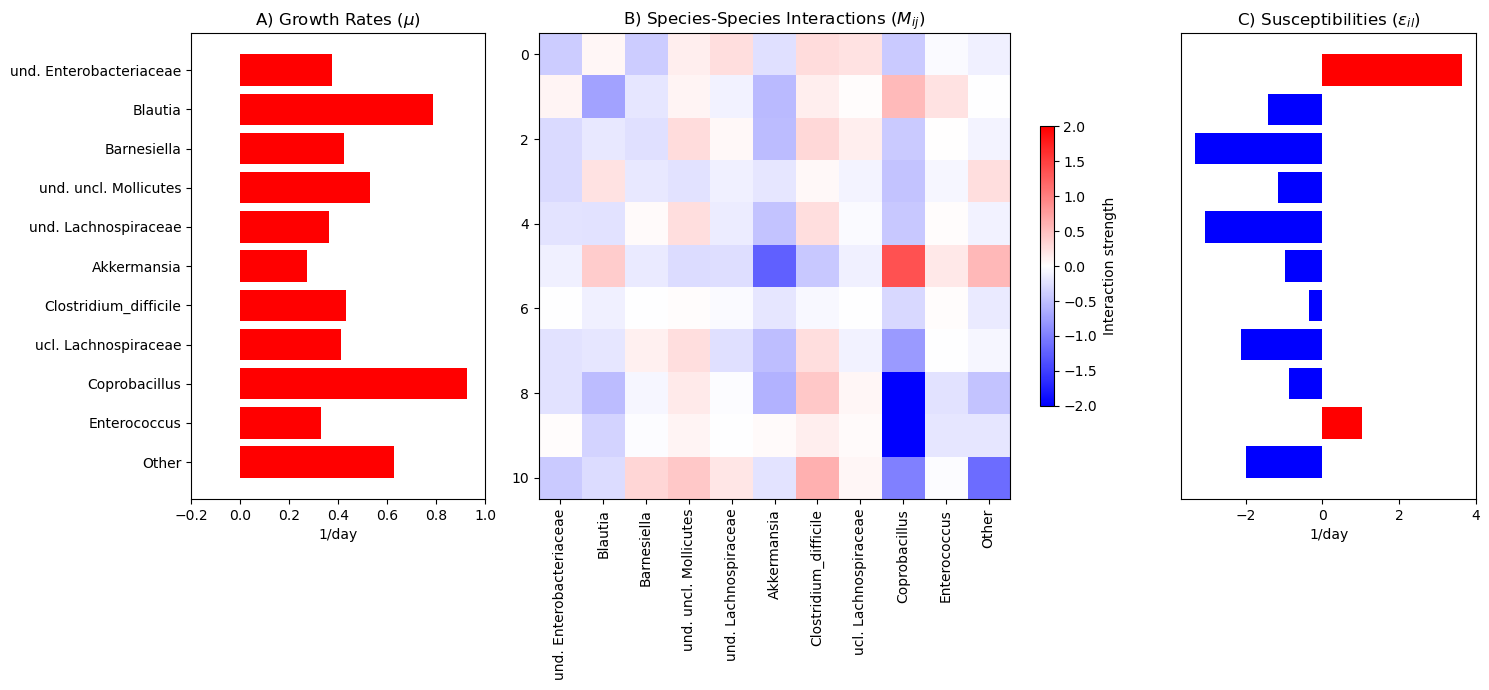

In [ ]:
species[0] = 'und. Enterobacteriaceae'
species[3] = 'und. uncl. Mollicutes'
species[4] = 'und. Lachnospiraceae'
species[7] = 'ucl. Lachnospiraceae'
# Create figure with constrained layout and custom width ratios
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 2, 1])  # Middle plot twice as wide

# Panel A: Growth rates (μ)
ax1 = fig.add_subplot(gs[0])
mu = theta[:, -2]  
colors = ['blue' if x < 0 else 'red' for x in mu]
ax1.barh(species[::-1], mu[::-1], color=colors)
ax1.set_xlabel('1/day')
ax1.set_title('A) Growth Rates ($\mu$)')
ax1.set_xlim(-0.2, 1.0)

# Panel B: Interaction matrix (M) - Make this wider
ax2 = fig.add_subplot(gs[1])
M = theta[:, :-2]  
cmap = LinearSegmentedColormap.from_list('custom', ['blue', 'white', 'red'], N=256)
cax = ax2.matshow(M, cmap=cmap, vmin=-2, vmax=2, aspect='auto')
# Add colorbar specifically for this subplot
cbar = fig.colorbar(cax, ax=ax2, label='Interaction strength', shrink=0.6)
ax2.set_title('B) Species-Species Interactions ($M_{ij}$)')
ax2.set_xticks(np.arange(len(species)))
ax2.set_xticklabels(species, rotation=90)
ax2.xaxis.set_ticks_position('bottom')

# Panel C: Susceptibilities (ε)
ax3 = fig.add_subplot(gs[2])
epsilon = theta[:, -1]  # Assuming last column is ε
colors = ['blue' if x < 0 else 'red' for x in epsilon[::-1]]
ax3.barh(species[::-1], epsilon[::-1], color=colors)
ax3.set_title('C) Susceptibilities ($\epsilon_{il}$)')
ax3.set_xlabel('1/day')
ax3.set_yticks([])  # Remove y-axis ticks
ax3.set_ylabel('')  # Remove y-axis label

# Adjust layout to prevent label clipping
plt.tight_layout()
# plt.savefig('../figure/model_para.svg', dpi=600)
plt.show()

Visualise the microbial interactions via graph

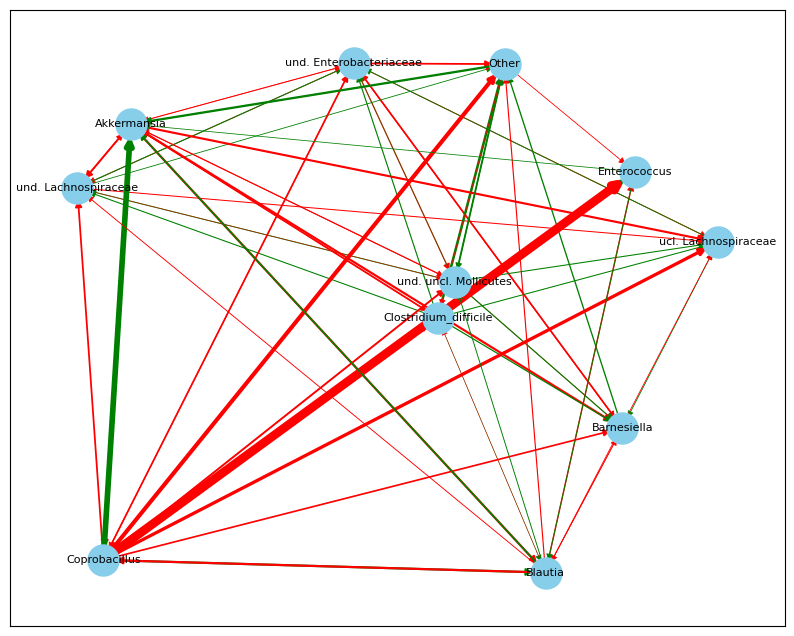

In [41]:
G = nx.DiGraph()
threshold = 0.1

for i, sp1 in enumerate(species):
    for j, sp2 in enumerate (species):

        if i != j and abs(M[i, j]) > threshold:
            G.add_edge(sp2, sp1, weight=M[i, j])

# Visualize
fig = plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=22)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_edges(
    G, pos, 
    edge_color=['red' if G[u][v]['weight'] < 0 else 'green' for u,v in G.edges()],
    width=[abs(G[u][v]['weight'])*3 for u,v in G.edges()]
)
nx.draw_networkx_labels(G, pos, font_size=8)
# plt.savefig('../figure/interaction_graph.svg', dpi=600)
plt.show()

Simulate the microbial dynamics using estimated model parameters.

In [42]:
# Define the gLV ODE
def f(t, x, mu, M, epsilon, perturb, u_t):
    u = u_t(t, perturb)
    dx_dt = x * (mu + M @ x + epsilon * u)

    return dx_dt

def u_t(t, perturb):

    if perturb == 1:
        if t == 0:
            return 1
        else:
            return 0
    else:
        return 0

# Define initial conditions and time span (here all use #2 replicate for three populations according to paper)
x0_1 = Y['4_0.0'].to_list()[:-2] # population 2 -> no pathogen, antibiotic perturbation at day 0
print(x0_1)
x0_2 = Y['5_0.0'].to_list()[:-2] # population 1 -> only pathogen, no antibiotic perturbation
x0_3 = Y['6_0.0'].to_list()[:-2] # population 3 -> pathogen infection after antibiotic perturbation at day 0
t_span = [0, 30]
t = np.linspace(0, 30, 100)

[4.5946e-05, 0.0004514, 0.067426, 0.00039497, 0.086895, 0.00056424, 0.0, 0.020934, 0.0002257, 1.9846e-05, 0.033064]


Visualise the computed microbial dynamics

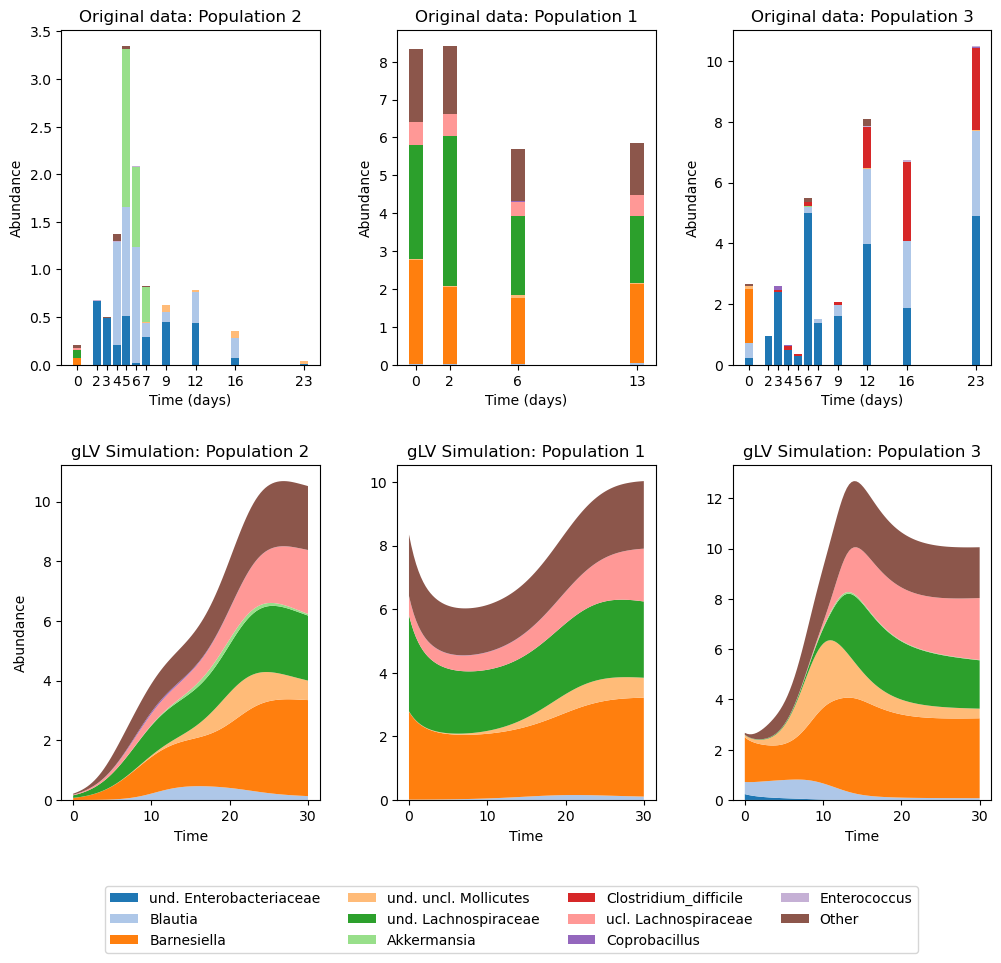

In [ ]:
# Set up figure and subplots
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 3, hspace=0.3, wspace=0.3)
color = plt.cm.tab20.colors[:len(species)]  # Assign each species a unique color
start_index = [25, 36, 40]
conditions =['Population 2', 'Population 1', 'Population 3']
x0 = [x0_1, x0_2, x0_3]
perturb = [1, 0, 1]

# Plot original data (top row)
for i in range(3):
    ax = fig.add_subplot(gs[0, i])
    
    # Initialize bottom for stacking
    time = all_time[i + 3].astype(float)
    bottom = np.zeros(len(time))
    
    # Plot each species as a stacked bar
    original_data = all_abundance_with_end[:, start_index[i]:start_index[i] + len(all_time[i + 3])]
    for sp in range(11):
        ax.bar(time, original_data[sp], width=0.8, 
               bottom=bottom, color=color[sp], label=species[sp])
        bottom += original_data[sp]  # Update bottom for next species
    
    ax.set_title(f"Original data: {conditions[i]}")
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Abundance')
    ax.set_xticks(time)  # Explicitly set x-ticks

# Plot simulated trajectories (bottom row)
for i in range(3):
    ax = fig.add_subplot(gs[1, i])
    x = solve_ivp(f, t_span, x0[i], method='LSODA',args=(mu, M, epsilon, perturb[i], u_t), dense_output=True)
    simulated_data = x.sol(t)
    ax.stackplot(t, simulated_data, labels=species, colors=color)
    ax.set_title(f"gLV Simulation: {conditions[i]}")
    ax.set_xlabel("Time")
    if i == 0:
        ax.set_ylabel("Abundance")

# Add a global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
# plt.savefig('../figure/model_sim.svg', dpi=600)
plt.show()